In [2]:
import os
import time
import shutil
import kagglehub
import torch
import torchvision
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import random
import skimage
from PIL import Image, ImageFile
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import ResNet18_Weights
from torchvision.datasets import ImageFolder


In [3]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False


In [4]:
# download the data

os.chdir(os.path.expanduser("~ir739wb/ilyarekun")) # change this for your machine
print(os.system("pwd"))


dst = os.path.expanduser("bc_project/data")  

# moving data to project folder
if not os.path.exists(dst):
    os.makedirs(dst)
    print("Data dir created successfully")
    
if os.listdir(dst) == []:
    path = kagglehub.dataset_download("andyczhao/covidx-cxr2")
    print("Path to dataset files:", path)
    shutil.move(path, dst)
    print("Data moved successfully")
print(os.system("pwd"))

%cd bc_project/data/
data_path = ('9')
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path,'test')
val_data_path = os.path.join(data_path, 'val')

train_df = pd.read_csv(os.path.join(data_path, 'train.txt'), sep=" ", index_col=None, header=None)
test_df = pd.read_csv(os.path.join(data_path, 'test.txt'), sep=" ", index_col=None, header=None)
val_df = pd.read_csv(os.path.join(data_path, 'val.txt'), sep=" ", index_col=None, header=None)

print(os.system('pwd'))
train_df.head()

train_df = train_df.rename(columns = {1:'image_name', 2:'diagnosis'})
test_df = test_df.rename(columns = {1:'image_name', 2:'diagnosis'})
val_df = val_df.rename(columns = {1:'image_name', 2:'diagnosis'})

train_df.drop(columns = [0,3], axis=1, inplace=True)
test_df.drop(columns = [0,3], axis=1, inplace=True)
val_df.drop(columns = [0,3], axis=1, inplace=True)


/home/ir739wb/ilyarekun
0
/home/ir739wb/ilyarekun
0
/home/ir739wb/ilyarekun/bc_project/data
/home/ir739wb/ilyarekun/bc_project/data
0


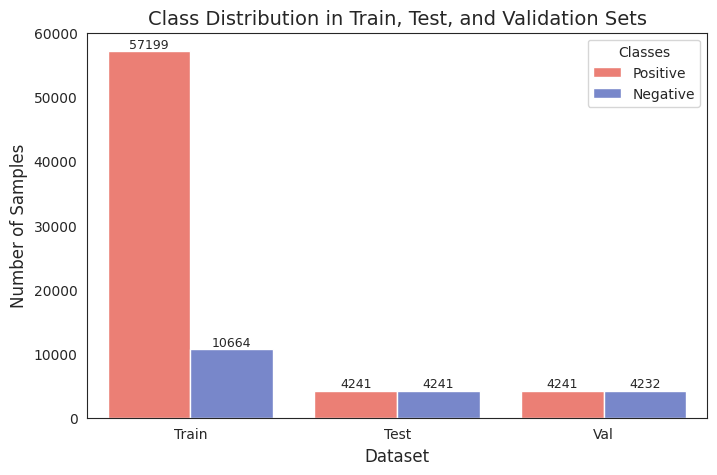

(67863, 2)
(8482, 2)
(8473, 2)


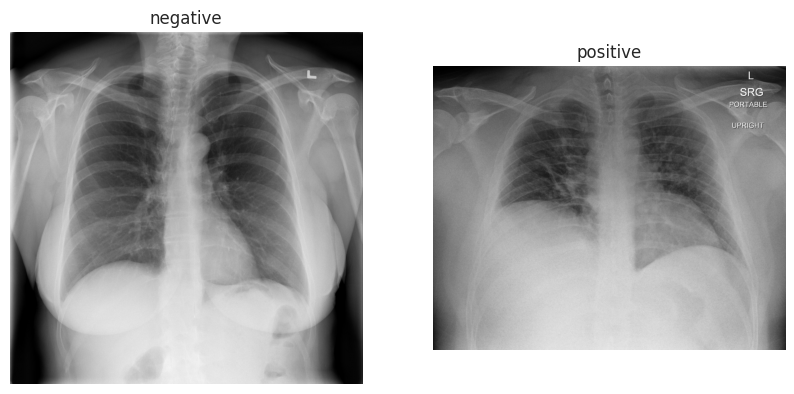

img_neg.shape (1024, 1024, 3)
img_pos.shape (826, 1024, 3)


In [5]:
a,b = train_df.diagnosis.value_counts()
c,d = test_df.diagnosis.value_counts()
e,f = val_df.diagnosis.value_counts()
graph = {
    'Datasets':["Train", "Train", "Test", "Test", "Val", "Val"],
    "Classes": ["Positive", "Negative", "Positive", "Negative", "Positive", "Negative"],
    'Count' : [a,b,c,d,e,f]
}
df = pd.DataFrame(graph)
sns.set_style("white")
plt.figure(figsize=(8, 5))
ax = sns.barplot(x="Datasets", y="Count", hue="Classes", data=df, palette=["#FF6F61", "#6B7FD7"])

for p in ax.containers:
    ax.bar_label(p, fmt="%.0f", fontsize=9, label_type="edge", padding=0)

plt.title("Class Distribution in Train, Test, and Validation Sets", fontsize=14)
plt.xlabel("Dataset", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.legend(title="Classes")
plt.show()

print(train_df.shape)
print(test_df.shape)
print(val_df.shape)

neg_idx = 0
pos_idx = 0

for idx,row in test_df.iterrows():
    if row['diagnosis'] == 'negative':
        neg_idx = idx
        break
for idx,row in test_df.iterrows():
    if row['diagnosis'] == 'positive':
        pos_idx = idx
        break
        
img_neg = cv2.imread(os.path.join(test_data_path, test_df.image_name[neg_idx]))
img_pos = cv2.imread(os.path.join(test_data_path, test_df.image_name[pos_idx]))

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img_neg/255)
plt.title(test_df.diagnosis[neg_idx])
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img_pos/255)
plt.title(test_df.diagnosis[pos_idx])
plt.axis('off')

plt.show()
print('img_neg.shape',img_neg.shape)
print('img_pos.shape', img_pos.shape)




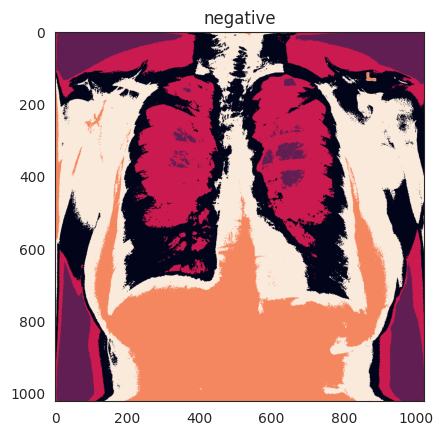

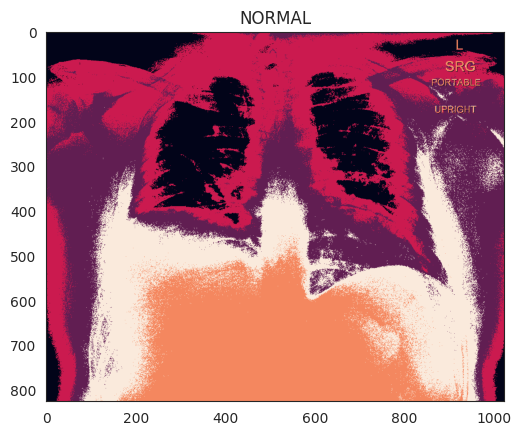

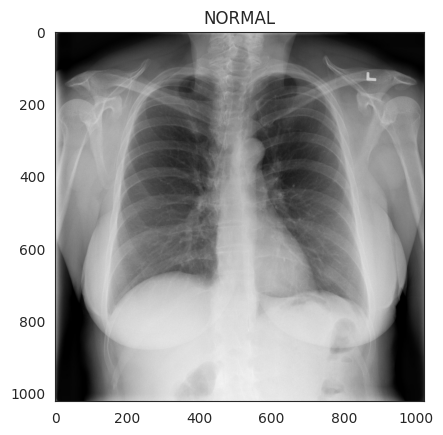

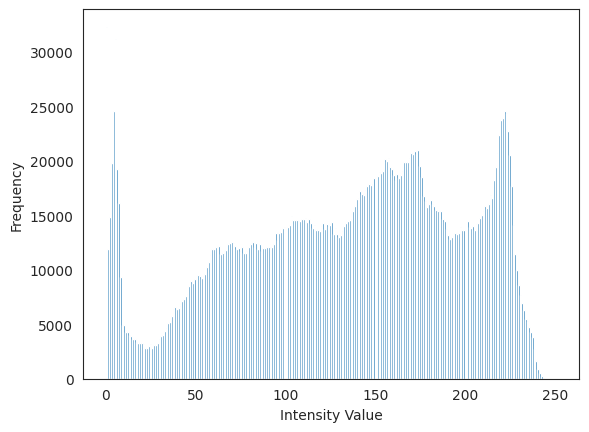

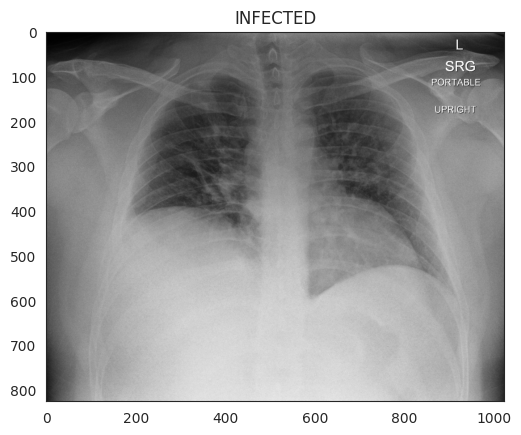

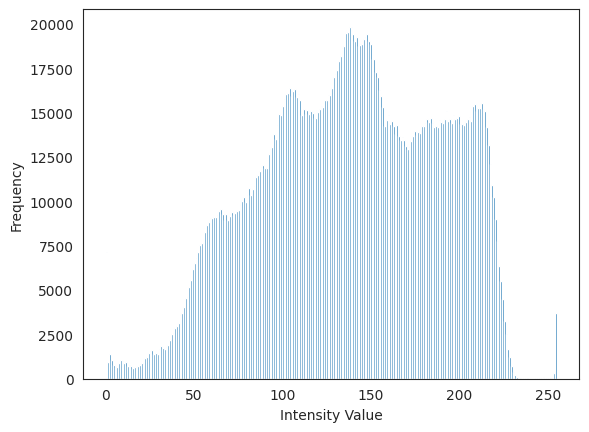

In [6]:
from sklearn import cluster

kmeans = cluster.KMeans(5)
dims = np.shape(img_neg)
pixel_matrix = np.reshape(img_neg, (dims[0] * dims[1], dims[2]))
clustered = kmeans.fit_predict(pixel_matrix)

clustered_img = np.reshape(clustered, (dims[0], dims[1]))
plt.imshow(clustered_img)
plt.title('negative')
plt.show()

kmeans = cluster.KMeans(5)
dims = np.shape(img_pos)
pixel_matrix = np.reshape(img_pos, (dims[0] * dims[1], dims[2]))
clustered = kmeans.fit_predict(pixel_matrix)


clustered_img = np.reshape(clustered, (dims[0], dims[1]))
plt.imshow(clustered_img)
plt.title("NORMAL")
plt.show()

from skimage import io
import matplotlib.pyplot as plt

plt.imshow(img_neg)
plt.title("NORMAL")
plt.show()

ax = plt.hist(img_neg.ravel(), bins = 256)
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.show()

plt.imshow(img_pos)
plt.title("INFECTED")
plt.show()

ax = plt.hist(img_pos.ravel(), bins = 256)
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')
plt.show()

In [7]:
class_counts = train_df["diagnosis"].value_counts().to_dict()
print(class_counts)  # {'negative': X, 'positive': Y}


{'positive': 57199, 'negative': 10664}


In [8]:
total_samples = sum(class_counts.values())
num_classes = len(class_counts)


In [9]:
class_weights = {cls: total_samples / (num_classes * count) for cls, count in class_counts.items()}
print(class_weights)



{'positive': 0.5932184129093167, 'negative': 3.1818735933983495}


In [10]:
print(train_df["diagnosis"].unique())  


['negative' 'positive']
